# 

In [1]:
import os
import pprint
import matplotlib.pyplot as plt
import re
import numpy as np
pprint = pprint.PrettyPrinter().pprint

We search the relevant directories, and make a dictionary of relevant filenames, attached to file stream objects

In [2]:
paths_of = lambda parent_path: os.listdir(parent_path)
dictionary_containing_all_file_names_and_values = lambda a_specific_top_level_path: dict(
    (a_specific_function_file,
    open(a_specific_top_level_path + "/" + a_specific_function_file,"r"))
    for a_specific_function_file in paths_of (a_specific_top_level_path)
)
data_structure_for = lambda base_path: dict(
    (a_specific_top_level_path, 
    dictionary_containing_all_file_names_and_values(base_path + "/" + a_specific_top_level_path))
    for a_specific_top_level_path in paths_of (base_path)
)

In [3]:
base_path = "../isolated_function_data_m4"

In [4]:
raw_data = data_structure_for (base_path)

Construct data point list dict, and characteristics dict

now that we have proof of concept, let's try this again with relevant maps:

In [5]:
curry_dict_map      = lambda f: lambda d: {k:f(v) for k,v in d.items()} #dictionary map lambda
read_all_text_map   = lambda file: file.read().splitlines()
point_cloud_map     = ... #need to take v, which is a file stream object, and read the correct 100 lines
characteristics_map = ... #need to take v, a file stream object, and read the last line
# full_observation_data = curry_dict_map(curry_dict_map(point_cloud_map))    (raw_data)
# characteristic_data   = curry_dict_map(curry_dict_map(characteristics_map))(raw_data)
# seems like we should read it in as text first
full_data = curry_dict_map(curry_dict_map(read_all_text_map))(raw_data)

In [6]:
full_data_split = curry_dict_map(curry_dict_map(lambda v: [x.split() for x in v]))(full_data)

In [7]:
key_tuples = [(a,b) for a in full_data_split.keys() for b in [*full_data_split[a]]]

In [8]:
import pandas as pd

In [9]:
def clean_kernprof(data):
    index_meanings = (
        # feature names for each datapoint in first 100 lines of data
        {#0: "function_name", #should never be used
         1: "min_execution_time_observed",
         2: "avg_execution_time_observed",
         3: "max_execution_time_observed",
         4: "last_execution_time",
         5: "number_of_times_executed",
         6: "total_time_of_all_executions"},
        # value names for line 100 gaussian model of points
        {0: "Total", #should never be used
         1: "time:", #should never be used
         2: "fastest_execution_set",
         3: "slowest_execution_set",
         4: "average_execution_set",
         5: "standard_deviation"}, 
        # names for various not very useful facts about the data below line 100
        {0:  "sample_min_min",
         1:  "sample_min_max",
         2:  "sample_min_avg",
         3:  "sample_min_std", #first line end
         4:  "sample_avg_min",
         5:  "sample_avg_max",
         6:  "sample_avg_avg", 
         7:  "sample_avg_std", #2nd line end
         8:  "sample_max_min",
         9:  "sample_max_max", 
         10: "sample_max_avg",
         11: "sample_max_std"} #3rd line end
    )
    characteristics = dict() 
    characteristics["function_name"] = data[0][0]
    characteristics["unit"] = "milliseconds"
    
    point_cloud = {index_meanings[0][x]: [] for x in index_meanings[0].keys()}
    
    for i,line in enumerate(data):
        for j,term in enumerate(line):
            if i<100 and j>0: #data points
                assert(j<7)
                point_cloud[index_meanings[0][j]].append(term)
            elif i==100 and j>1: #summary stats
                assert(j<6)
                characteristics[index_meanings[1][j]] = term.split(":")[1]
            elif i>100: 
                assert(j<4)
                characteristics[index_meanings[2][j+4*(i%101)]] = term.split(":")[1]
    point_cloud = pd.DataFrame(point_cloud)
    return [characteristics, point_cloud]
    
def clean_line_prof(data):
    index_meanings = (
        # feature names for each datapoint in first 100 lines of data
        {#0: "line_num_in_py_script",
         #1: "num_times_executed",
         2: "total_time_spent_on_line",
         3: "time_per_execution_of_line",
         4: "percent_of_total_runtime_spent_on_line"},
         #5: "command_being_run"
        # value names for line 100 gaussian model of points
        {0: "Total", #should never be used
         1: "time:", #should never be used
         2: "fastest_execution_set",
         3: "slowest_execution_set",
         4: "average_execution_set",
         5: "standard_deviation"}, 
        # names for line 101 gaussian model of total runtime %
        {0:  "percent_min",
         1:  "percent_max",
         2:  "percent_avg",
         3:  "percent_std"}
    )
    characteristics = dict() 
    characteristics["line_num_in_py_script"] = data[0][0]
    characteristics["num_times_executed"] = data[0][1]
    characteristics["command_being_run"] = data[0][5]
    characteristics["unit"] = "1e-06 seconds"

    point_cloud = {index_meanings[0][x]: [] for x in index_meanings[0].keys()}

    for i,line in enumerate(data):
        for j,term in enumerate(line):
            if i<100 and j>1 and j<5: #data points
                # line#inPyScript #ofExecutions totalLineTime timePerExec %ofTotalTime lineExecuted
                # of these, ^          ^                                                 and^ are characteristics
                # only totalLineTime, timePerExec, and  %ofTotalTime are variable between observations
                point_cloud[index_meanings[0][j]].append(term)
            elif i==100 and j>1: #summary stats
                assert(j<6)
                characteristics[index_meanings[1][j]] = term.split(":")[1]
            elif i==101: 
                assert(j<4)
                characteristics[index_meanings[2][j]] = term.split(":")[1]
    point_cloud = pd.DataFrame(point_cloud)
    return [characteristics, point_cloud]
    
def clean_line_prof_total_time(data):
    index_meanings = (
        # feature names for each datapoint in first 100 lines of data
        {#0: "total", #should never be used
         #1: "time:", #should never be used
         2: "total_runtime_for_ith_run"},
         #3: "s" #should never be used
        # value names for line 100 gaussian model of points
        {0: "Total", #should never be used
         1: "time:", #should never be used
         2: "fastest_execution",
         3: "slowest_execution",
         4: "average_execution",
         5: "standard_deviation"} 
    )
    characteristics = dict() 
    characteristics["unit"] = "seconds"
    
    point_cloud = {index_meanings[0][x]: [] for x in index_meanings[0].keys()}

    for i,line in enumerate(data):
        for j,term in enumerate(line):
            if i<100 and j>1 and j<3: #data points
                assert(j==2)
                point_cloud[index_meanings[0][j]].append(term)
            elif i>=100 and j>1: #summary stats
                assert(j<6)
                characteristics[index_meanings[1][j]] = term.split(":")[1]
    point_cloud = pd.DataFrame(point_cloud)
    return [characteristics, point_cloud]

In [10]:
final_data = dict() 
line_profile_total_time = dict()
for key in [*full_data_split.keys()]:
    final_data[key] = dict()
for tuple in key_tuples:
    if "kernprof" in tuple[0] and "totalTime" not in tuple[1]:
        final_data[tuple[0]][tuple[1]] = clean_kernprof(full_data_split[tuple[0]][tuple[1]])
    if "line_profiler" in tuple[0] and "totalTime" not in tuple[1]:
        final_data[tuple[0]][tuple[1]] = clean_line_prof(full_data_split[tuple[0]][tuple[1]])
    elif "totalTime" in tuple[1]:
        line_profile_total_time[tuple[1]] = clean_line_prof_total_time(full_data_split[tuple[0]][tuple[1]])

Ok, so now we have succesfully turned all relevant data into python objects that can be worked with more easily.
The final data is in the form: 
{
directory1:   {file1:(characteristics,point_cloud), 
               file2:...                          
              }, 
directory2:   {...
              },
...
}

Meanwhile the line_prof_total_time data is in the form:
{
file1: (characteristics, point_cloud),
file2: (characteristics, point_cloud)
}

where one file relates to fwddyn and one to invdyn.

I want to represent this data in easily comprehsible ways, that reveal important relationships between and within functions.

There are a few charts that have obvious use:
- bar chart comparing fwddyn with invdyn, with each time sink indicated by a colored region of the bar
- a gaussian distribution model of data points, for all point sets
- a box plot showing quartiles and outliers for fwd and inv dyn.
- a bar chart indicating the share of time different functions take out of total time, for both the python line_prof and also the c++ kernprof, for both inv and fwd dyn.

Before we can start on that however, there is an issue. The sums of function times is not equal to the total execution time of the program! Here's an example using real data:

In [11]:
# Sum up the average times for each approach and timer tool
account_for_unit = lambda val, dir: (val*0.001) if (unit:=(final_data[dir][[*final_data[dir].keys()][0]][0]["unit"]) == "milliseconds") else (val*1e-06)
get_average_of_dir = lambda dir: account_for_unit(sum([float(re.sub(",","",file[0]["average_execution_set"])) for file in [final_data[dir][x] for x in final_data[dir].keys()]]),dir)
fwddyn_kernprof_total  = get_average_of_dir('fwddyn_kernprof_output_data')
fwddyn_line_prof_total = get_average_of_dir('fwddyn_line_profiler_output_data')
invdyn_kernprof_total  = get_average_of_dir('invdyn_kernprof_output_data')
invdyn_line_prof_total = get_average_of_dir('invdyn_line_profiler_output_data')

In [12]:
print(fwddyn_kernprof_total,
      fwddyn_line_prof_total,
      invdyn_kernprof_total,
      invdyn_line_prof_total)

0.30069525252525253 1.7003009606060604 0.2787816161616162 1.700346686868687


The issue is that these values don't match! They are supposed to be essentially the same data, so what's the deal?

In [13]:
print("approx time for fwd kernprof", (0.95+49.57+0.44+1.50+1.29+2.18+0.56+1.68+2.69+0.49+1.85+26.35+50.74+77.13+5.81+18.59+18.53+96.89)/1000, " s")
print("approx time for fwd kernprof, counting only solve", 93/1000, " s")
print("approx time for fwd lineprof", 1.7, " s")
print("approx time for fwd lineprof, excluding model load", (3150+454+93012)/1e6, " s")
print("approx time for inv kernprof", (0.63+36.39+0.41+1.29+1.08+2.10+0.49+1.61+2.46+27.19+37.18+64.48+5.65+12.37+0.74+2.73+37.26+6.79+77.70+12.61+0.39+0.10+64.51+0.01+0.05+64.49+0.04+12.47)/1000, " s")
print("approx time for inv kernprof, counting only solve", 83/1000, " s")
print("approx time for inv lineprof", 1.7, " s")
print("approx time for inv lineprof, excluding model load", (3443+624+86692)/1e6, " s")

approx time for fwd kernprof 0.35724  s
approx time for fwd kernprof, counting only solve 0.093  s
approx time for fwd lineprof 1.7  s
approx time for fwd lineprof, excluding model load 0.096616  s
approx time for inv kernprof 0.4732200000000001  s
approx time for inv kernprof, counting only solve 0.083  s
approx time for inv lineprof 1.7  s
approx time for inv lineprof, excluding model load 0.090759  s


one easy explanation is that the c++ profiler doesn't time everything, only distinct functions, and  some stuff is missing from that, so the real time is 1.7s
but that doesn't make a lot of sense, because if we ignore the load time of the robot model, which is the vast majority of the time for the program,
then the remainder is less than what is reported for the kernprof -- meaning kernprof must be over-reporting, since the only other possibility is that it is recording during
the model load and also not recording everything, but we know that's not it because none of the fucntions being timed are related to model loading.

therefore we can deduce that at least one of a few things is true:
1. the units aren't correct in the file (highly unlikely)
2. kernprof is way overcounting time somehow, ie. I'm counting the running time of both parent and child functions (definitely true, maybe not the full answer)
3. there is significant parallel runtime for the functions 

Ok so this is progress, we know that we are overcounting in kernprof.
The issue is now, what can we count as a unique function? It seems like we are missing about 0.004 to 0.007 seconds, which may indicate that solve isn't the parent of all the functions.

There is a hint in the number of iterations for each function. In inv kernprof for instance, some functions iterate once, while others run 25, 17, or 1700 times. 
It is fairly obvious that 1700 iteration counts is a loop running within the 17 count iteration step. Meanwhile, it is likely that 25 iteration count functions are in another seperate loop.
This isn't certain, the fast functions could just happen to be iterating 1700 times, while the 25 iteration count functions could be simply executing based on conditionals, but be in the 1700 loop. Or both of these things could be true simultaneously, if these functions are being called multiple times from different places in the  file.

However, this ambiguity is somewhat mitigated by the labels of the functions, which indicate the object the function is being called from. For instance:

SolverIntro::Vx                                             
SolverIntro::Vxx                                            
SolverIntro::calcDiff                                       
SolverIntro::computeGains                                   
SolverIntro::solve                                          
SolverIntro::solve::calcDerivatives                         
SolverIntro::solve::callbacks                               
SolverIntro::solve::expectedImprovement                     
SolverIntro::solve::loop2                                   
SolverIntro::solve::regularization                          
SolverIntro::solve::setCandidate1                           
SolverIntro::solve::updatepenaltyparameter

These functions are likely closely related to each other because of this similarity. However, each of these have widely varrying iteration counts in some cases, often iteration counts that match the iteration counts of other object functions of different objects, meaning the relation between these is not any stronger than the relation between functions with matching iteration counts, or functions with iteration counts that have common divisors.

It seems safe to conclude that this needs to be accompanied by a structural analysis of the c++ script being run.
Looking at the recent commits of profiling lines to the forked crocoddyl repo, and referencing my own recollection, I conclude that most of these functions are being run or called in ddp.cpp, fddp.cpp, and intro.cpp.

Looking at the function timing lists in the raw data from kernprof, I can begin to work out which of these files is being called by which usecase (INV or FWD).

fddp.cpp contains the following------------------

- SolverFDDP::solve, 
- SolverFDDP::forwardPass

ddp.cpp contains the following-------------------

- SolverDDP::solve, 
- SolverDDP::computeDirection, 
- SolverDDP::tryStep :
    - LOOKHERE 
- SolverDDP::resizeData, 
- SolverDDP::calcDiff, 
- SolverDDP::backwardPass, 
- SolverDDP::forwardPass, 
- SolverDDP::Qx, 
- SolverDDP::Qxx, 
- SolverDDP::Qu, 
- SolverDDP::Quu, 
- SolverDDP::Qxu, 
- SolverDDP::Vx, 
- SolverDDP::Vxx, 
- SolverDDP::computeGains :
    - SolverDDP::Quu_inv,
    - SolverDDP::Quu_inv_Qux (conditionals) 

intro.cpp contains the following-----------------

- SolverIntro::solve :
    - SolverIntro::solve::loop2,
    - computeDirection,
    - increaseRegularization,
    - SolverIntro::solve::expectedImprovement,
    - SolverIntro::solve::updatepenaltyparameter,
    - SolverIntro::solve::calcDerivatives :
        - tryStep,
        - expectedImprovement,
        - olverIntro::solve::setCandidate1 (conditionals)
        - SolverIntro::solve::setCandidate2 (conditionals)
    - SolverIntro::solve::callbacks
    - SolverIntro::solve::regularization (conditionals)
- SolverIntro::resizeData
- SolverIntro::calcDiff
- SolverIntro::Vx
- SolverIntro::Vxx
- SolverIntro::computeGains
    - SolverIntro::Qzz_inv
 
This gives a rough idea of the hierarchy of the timed statements as they are written in the code. However, we don't know if all of these are being used even, and furthermore some could call others behind the scenes or indirectly, further complicating their relationship.

Our first step therefore is to verify which of these are being run, and by which problem (INV or FWD). To do this we just check our current list against the lists in the kernprof raw outputs.

invdyn uses: ------------------------------------

- ShootingProblem::calc                          
- ShootingProblem::calcDiff                      
- SolverDDP::Qu                                  
- SolverDDP::Quu                                 
- SolverDDP::Quu_inv                             
- SolverDDP::Quu_inv_Qux                         
- SolverDDP::Qx                                  
- SolverDDP::Qxu                                 
- SolverDDP::Qxx                                 
- SolverDDP::backwardPass                        
- SolverDDP::calcDiff                            
- SolverDDP::computeDirection                    
- SolverDDP::computeGains                        
- SolverFDDP::forwardPass                        
- SolverIntro::Vx                                
- SolverIntro::Vxx                               
- SolverIntro::calcDiff                          
- SolverIntro::computeGains                      
- SolverIntro::solve                             
- SolverIntro::solve::calcDerivatives            
- SolverIntro::solve::callbacks                  
- SolverIntro::solve::expectedImprovement        
- SolverIntro::solve::loop2                      
- SolverIntro::solve::regularization             
- SolverIntro::solve::setCandidate1              
- SolverIntro::solve::updatepenaltyparameter     
- computeDirection                               
- expectedImprovement                            
- tryStep                                        

Which utilizes all three files, and an extra "ShootingProblem" file. We know computeDirection, expectedImprovement, and tryStep are all into.cpp routines, and of course all the SolverIntro items are as well. Meanwhile only SolverFDDP::forwardPass is used from fddp.cpp. SolverDDP from ddp.cpp provides solutions to the quadratic problems (ie. all the Qs) as well as the backwardPass and some other calculations. Finally ShootingProblem provides calc, and calcDiff. 

Checking commits didn't reveal the ShootingProblem profiler calls for some reason, so I searched for the symbol in the entire repo, but the repo was being indexed still so I went to the official crocoddyl repo instead, and searching there turned up the profiler statement. Seems like this is from the developers of crocoddyl themselves, and was simply never removed; possibly this was an accident. It appears in the shooting.hxx internal header file, which makes me feel uncertain that we should even be using it in our calculations (because it isn't a publicly accssible header, and is only for project internal use). 

It also isn't clear to me how calc and calcdiff relate in hierarchy to the other functions we are profiling.

Meanwhile, if we take a look fwddyn:

fwddyn uses: ------------------------------------
- LOOKHERE                                                   
- ShootingProblem::calc                                      
- ShootingProblem::calcDiff                                  
- SolverDDP::Qu                                              
- SolverDDP::Quu                                             
- SolverDDP::Quu_inv                                         
- SolverDDP::Quu_inv_Qux                                     
- SolverDDP::Qx                                              
- SolverDDP::Qxu                                             
- SolverDDP::Qxx                                             
- SolverDDP::Vx                                              
- SolverDDP::Vxx                                             
- SolverDDP::backwardPass                                    
- SolverDDP::calcDiff                                        
- SolverDDP::computeDirection                                
- SolverDDP::computeGains                                    
- SolverDDP::tryStep                                         
- SolverFDDP::forwardPass                                    
- SolverFDDP::solve                                          

Here we observe a similar setup. The most notable change is that we no longer use intro at all, replacing intro solve with fddp solve instead. The ShootingProblem calc and calcdiff make an appearance again as well, likely indicating that they are quite fundamental to the multishot process. From the names and comments at their definition in the header files, it seems they are responsible for calculating the possible options for shooting, and also possibly for estimating the gradient for shooting.

Similarly, the ddp value function approximation and quadratic problem solutions appear again. Presumably the way these problems are solved is fairly generic, and so the same method is used even in various FDDP applications.


Now that we have a rough sense of things, it is time to start to try and reconstruct the runtime hierarchy of the various functions. The first thing I did was experimentally verify that the number of iterations of each function was consistent between trials. I only checked a handful of different raw data files, but they do seem to be consistent.

That out of the way, we need to organize the inv and fwd function measures into a hierarchy in the same way we did for all the profiler calls in the cpp files themselves. Then we will give a best attempt at finding divisions between the functions that are faithful to the total time reported by the line profiler; this  may be a process of trial and error unfortunately. 

fwddyn: ------------------------
- ShootingProblem::calc        ran for    1     iterations in        0.91   milliseconds    
- ShootingProblem::calcDiff    ran for    16    iterations in        48.29  milliseconds    

- SolverDDP::Qu                ran for    1600  iterations in        0.44   milliseconds    
- SolverDDP::Quu               ran for    1600  iterations in        1.36   milliseconds    
- SolverDDP::Qx                ran for    1600  iterations in        0.53   milliseconds    
- SolverDDP::Qxu               ran for    1600  iterations in        1.66   milliseconds    
- SolverDDP::Qxx               ran for    1600  iterations in        2.59   milliseconds    
- SolverDDP::Vx                ran for    1600  iterations in        0.52   milliseconds    
- SolverDDP::Vxx               ran for    1600  iterations in        1.46   milliseconds    
- SolverDDP::backwardPass      ran for    16    iterations in        24.68  milliseconds    
- SolverDDP::calcDiff          ran for    16    iterations in        49.40  milliseconds    
- SolverDDP::computeDirection  ran for    16    iterations in        74.13  milliseconds    
- SolverDDP::computeGains      ran for    1600  iterations in        5.46   milliseconds    
    - SolverDDP::Quu_inv           ran for    1600  iterations in        1.09   milliseconds    
    - SolverDDP::Quu_inv_Qux       ran for    1600  iterations in        2.06   milliseconds    
- SolverDDP::tryStep           ran for    18    iterations in        17.84  milliseconds    

- SolverFDDP::forwardPass      ran for    18    iterations in        17.80  milliseconds    
- SolverFDDP::solve            ran for    1     iterations in        93.00  milliseconds    

*note that I removed LOOKHERE as it was an obvious child that did not add any information

With this hierarchy, assuming there is no idirect calling or relations between the files (highly unlikely), there are 2 sums that make sense to note as possible better values.
1. summing all times except Quu_inv and Quu_inv_Qux, since they are likely accounted for in comoputeGains already
2. same as above except we don't include the ShootingProblem measures either

These strategies yield a value of of 340.07 ms and 290.87 ms respectively. Our goal value we calculated to be about 97 ms for fwddyn previously, but let's switch to using the same execution for both the lineprof and  kerprof results, so that even if there are random movements in times these should be the same random movements captured by both tools. Checking the line_prof results for this particular example, we get: 1,743.24 ms, and deleting the model loading and profiler handling itself, we reach 96.83 ms. It is not clear whether all the calls that are being counted are actually in any way related to the profiled functions, but the main bottleneck solver.solve() definitely is related, and so at the very least 93.01 ms are spent on related steps. That doesn't mean that the kernprof values should add to exactly that value, but it should hopefully be fairly close, and certainly shouldn't exceed the 96.83 ms value. 

To make that work, we should start with known independant values. SolverFDDP::solve takes 93 milliseconds, which is more than any other function; this means that no other function can be its parent so it must be a unique measurement. From there, we have somewhere between 0 and 4 more milliseconds, meaning that all the other large time cost functions must be children of solve, since they can't fit in the correct time frame otherwise. In fact, any function that takes more than 3.8 ms total must be a child of solve.

We can also observe that SolverDDP::calcDiff takes just a few milliseconds longer than ShootingProblem::calcDiff, implying that the former is relying on the latter for most of the computation in that step; they are most likely essentially the same function, with perhaps a couple fast extra compute steps in SolverDDP. Similarly, the tryStep runs for just 0.04 milliseconds longer than the forwardPass step, meaning it is functionally just calling the forwardPass phase directly, with a conditional try to gaurd against errors.
The same logic applies to combinations of children functions too: the SolverDDP::computeDirection step is simply too large not to have children, and notably the two preceeding large steps (backwardPass and calcDiff) sum to 74.08 ms, just 0.05 ms less than the runtime of computeDirection. Finally, the sum of the tryStep and computeDirection step gets us to 91.97 ms, just barely a millisecond off from the total, so these are almost certainly the 2 main direct children of solve.

The amount of time remaining for direct children isn't large enough for the SolverDDP::computeGains step, so it must be the child of one of these two. Since computeGains ran 1600 times, it makes sense that it may have been run 100 times for each iteration of computeDirection, which ran 16 times. That said, there isn't enough room under computeDirection for it either, so it must be an even lower level child. Similar reasoning for iterations would lead us to believe that the quadratic problems and value function approximations are also happening somewhere in computeDirection. It would also make sense to say that the quadratic problems are likely all solved in the same loop, However all of them together can't fit inside the computeGains loop that already holds the Quu_inv and Quu_inv_Qux calculations. What's more, the largest quadratic solve takes 2.59 ms, which is too large to fit in computeGains or its children. They are also too large as a group to fit in SolverDDP::calcDiff, so they must go in the backwardPass instead.

Finally, ShootingProblem::calc is only called once, so if it were inside any of the child loops it would have to be hidden behind conditionals somehow. The more likely explanation in this case is that it is either a direct child of solve, or not a child of any function. As mentioned earlier, only one millisecond isn't already accounted for in the body of solve, and this is most likely it. This brings the total accounted for time in the solve function up to 92.88, just 0.12 ms from the 93 ms run time of the function.

This is quite a bit of speculation, so I went ahead and traced the code to confirm the hierarchy. The final product is as follows:

fwddyn: ------------------------
- SolverFDDP::solve            ran for    1     iterations in        93.00  milliseconds    
    - SolverDDP::tryStep           ran for    18    iterations in        17.84  milliseconds    
        - SolverFDDP::forwardPass      ran for    18    iterations in        17.80  milliseconds    
    - SolverDDP::computeDirection  ran for    16    iterations in        74.13  milliseconds            
        - SolverDDP::backwardPass      ran for    16    iterations in        24.68  milliseconds            
            - *SolverDDP::computeActionValueFunction*
                - SolverDDP::Qu                ran for    1600  iterations in        0.44   milliseconds    
                - SolverDDP::Quu               ran for    1600  iterations in        1.36   milliseconds    
                - SolverDDP::Qx                ran for    1600  iterations in        0.53   milliseconds    
                - SolverDDP::Qxu               ran for    1600  iterations in        1.66   milliseconds    
                - SolverDDP::Qxx               ran for    1600  iterations in        2.59   milliseconds    
            - SolverDDP::computeGains      ran for    1600  iterations in        5.46   milliseconds
                - SolverDDP::Quu_inv           ran for    1600  iterations in        1.09   milliseconds    
                - SolverDDP::Quu_inv_Qux       ran for    1600  iterations in        2.06   milliseconds    
            - *SolverDDP::computeValueFunction*
                - SolverDDP::Vx                ran for    1600  iterations in        0.52   milliseconds    
                - SolverDDP::Vxx               ran for    1600  iterations in        1.46   milliseconds    
        - SolverDDP::calcDiff          ran for    16    iterations in        49.40  milliseconds            
            - ShootingProblem::calcDiff    ran for    16    iterations in        48.29  milliseconds        
            - ShootingProblem::calc        ran for    1     iterations in        0.91   milliseconds    
            
I was able to expereimentally confirm all function placements, which was quite straightforward except for the ShootingProblem functions, which are called in a way that I do not understand. My best understanding is that calc and calcDiff are called in functions that are defined in a different namespace (ie. SolverDDP). Because they are in this namespace, they have access to the functions defined in that namespace, which includes ShootingProblem::calc and ShootingProblem::calcDiff because SolverDDP inherits from solver-base, which takes a shooting probem problem formulation for initiaization, on which the calc and calcDiff functions are declared. However even there they aren't well defined, and it is unclear to me where the definition lies. That said, calc is called only three times in dpp.cpp, and 2 of those are in the SolverDDP::forwardPass function, which is not used in this case in favor of SolverFDDP's version. The only remaining option is that it is being called from the 3rd call, which is in the SolverDDP::calcDiff function. This is also where the only viable call to calcDiff is.

Finally, I added a few parent functions in (the italicized rows), because they were missing from the original chain of profiled functions, and are important wrappers on the children that were already being profiled.

Now we simply need to apply the same process to the invdyn version. 

invdyn: -----------------------------------
- SolverIntro::solve                                          ran for8      1     iterations  in    83.48  milliseconds   
    - SolverIntro::updatepenaltyparameter                  ran for       17    iterations  in    0.00   milliseconds   
    - SolverIntro::tryStep                                                     ran for       25    iterations  in    14.50  milliseconds   
        - SolverFDDP::forwardPass                                     ran for       25    iterations  in    14.40  milliseconds   
    - SolverDDP::computeDirection                                 ran for       17    iterations  in    68.04  milliseconds   
        - SolverDDP::backwardPass                                     ran for       17    iterations  in    28.18  milliseconds   
            - *SolverDDP::computeActionValueFunction*
                - SolverDDP::Qu                                               ran for       1700  iterations  in    0.43   milliseconds   
                - SolverDDP::Quu                                              ran for       1700  iterations  in    1.39   milliseconds   
                - SolverDDP::Qx                                               ran for       1700  iterations  in    0.55   milliseconds   
                - SolverDDP::Qxu                                              ran for       1700  iterations  in    1.68   milliseconds   
                - SolverDDP::Qxx                                              ran for       1700  iterations  in    2.61   milliseconds   
            - SolverIntro::computeGains                                   ran for       1700  iterations  in    6.87   milliseconds   
                - SolverDDP::computeGains                                     ran for       1700  iterations  in    5.73   milliseconds   
                    - SolverDDP::Quu_inv                                          ran for       1700  iterations  in    1.11   milliseconds   
                    - SolverDDP::Quu_inv_Qux                                      ran for       1700  iterations  in    2.14   milliseconds   
            - *SolverIntro::computeValueFunction*
                - SolverIntro::Vx                                             ran for       1700  iterations  in    0.77   milliseconds   
                - SolverIntro::Vxx                                            ran for       1700  iterations  in    2.81   milliseconds   
        - SolverIntro::calcDiff                                       ran for       17    iterations  in    39.82  milliseconds
            - *SolverFDDP::calcDiff*
                - SolverDDP::calcDiff                                         ran for       17    iterations  in    39.75  milliseconds   
                    - ShootingProblem::calc                                       ran for       1     iterations  in    0.68   milliseconds   
                    - ShootingProblem::calcDiff                                   ran for       17    iterations  in    38.88  milliseconds   

I added relevant functions, and removed entries that were measuring the function call directly where the function being called lay in another namespace, file, or class (ie. delete SolverIntro::computeDirection in favor of SolverDDP::computeDirection). Some items, like regularization, hadn't had their equivalent functions recorded for fwddyn, so I deleted them. This seems fine since they were small enough to be inconsiquential, but we should do a better job measuring them in the future. I think both versions use SolverDDP::increaseRegularization, but someone would need to verify this. Similarly, expectedImprovement seems to be be used in both cases as well, and is defined in fddp.cpp. In this case though, it is called in 2 places in SolvereIntro.solve, and is measured seperately as two different items for each. The profiler should be moved too the function definition in fddp.cpp. I also deleted loop2 as it doesn't correspond to anything we care about at this point. calcDerivatives was deleted because it measures something very similar to tryStep, and tryStep has a direct equivalent in fwddyn already so it is better for comparison. setCandidate should be recorded, but it isn't recorded for fwddyn, so deleted. Finally I deleted the callbacks function as well, since this is an identical cost for fwddyn that wasn't measured on that side, though it should be measured in future.

Beyond deletions, it seems SolverIntro::calcDiff actually adds onto SolverFDDP::calcDiff and calls it directly, so that should certainly be part of the measured values here. SolverFDDP happens to rely on SolverDDP for  calcDiff, so SolverDDP::calcDiff is represented here (and consequently ShootingProblem::calc and calcDiff), but that is mainly incidental. Actually n/m that is wrong, SolverFDDP inherits from DDP, and doesn't define it's own calcDiff or computeGains, so both of these go straight to SolverDDP, although meaningful additions are made in intro.cpp so I would advise keeping the extra profiling there in this case.

Also I'll note that it seems like SolverDDP::computeDirection is calling SolverIntro::calcDiff which is strange to me, but seems to be true.

Now that we have sorted every function into the proper spot in the hierarchy, each layer is an equivalent representation of where the time to execute is going, though the lower the layer of the hierarchy the more detailed it is.

Now we finally get back to graphing the data. Our lambdas from earlier were a good start, but they will require some modification. Like before thou

fwddyn_kernprof_output_data
fwddyn_line_profiler_output_data
invdyn_kernprof_output_data
invdyn_line_profiler_output_data
[array([13.72676768,  0.        , 13.44606061,  0.        ]), array([23.21979798,  0.        , 27.94858586,  0.        ]), array([44.08959596,  0.        , 38.49676768,  0.        ]), array([  0.        , 432.21919192,   0.        , 490.79090909]), array([    0.        , 81768.66363636,     0.        , 80968.35353535]), array([      0.        , 1615139.39393939,       0.        ,
       1615908.25151515])]
[0 1]


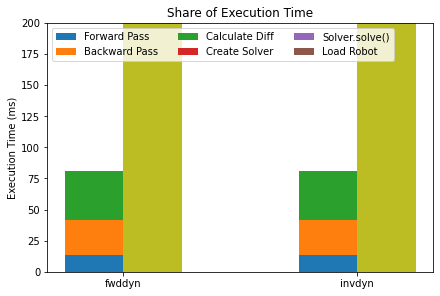

In [62]:
fwd = list()
bwd = list()
cdf = list()
crs = list()
cal = list()
loa = list()

def get_average_of_dir (dir):
    print(dir)
    files = [(x,final_data[dir][x]) for x in final_data[dir].keys()]
    for filename,contents in files:
        characteristics = contents[0]
        average_time = float(re.sub(",","",characteristics["average_execution_set"]))
        if characteristics["unit"]=="milliseconds":
            #average_time/=1000
            ...
        elif characteristics["unit"]=="1e-06":
            average_time/=1000
        if "kernprof" in filename:
            if "forwardPass" in filename:
                fwd.append(average_time)
                
                crs.append(0)
            elif "backwardPass" in filename:
                bwd.append(average_time)
                
                cal.append(0)
            elif "calcDiff" in filename and "DDP" in filename:
                cdf.append(average_time)
                
                loa.append(0)
        if "line" in  filename:
            if "create" in filename:
                crs.append(average_time)
                
                fwd.append(0)
            elif "call" in filename:
                cal.append(average_time)
                
                bwd.append(0)
            elif "load" in filename:
                loa.append(average_time)
                
                cdf.append(0)
            

labels = (
    'fwddyn',
    'invdyn'
)
dir_names = (
    'fwddyn_kernprof_output_data',
    'fwddyn_line_profiler_output_data',
    'invdyn_kernprof_output_data',
    'invdyn_line_profiler_output_data'
)
for dir in dir_names:
    get_average_of_dir(dir)
    
weight_counts = {
    "Forward Pass": np.array(fwd),#[:2],fwd[2:]]),
    "Backward Pass": np.array(bwd),#[:2],bwd[2:]]),
    "Calculate Diff": np.array(cdf),#[:2],cdf[2:]]),
    "Create Solver": np.array(crs),
    "Solver.solve()": np.array(cal),
    "Load Robot": np.array(loa)
}
print([*weight_counts.values()])

thing = np.arange(len(labels))  # the label locations
print(thing)
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
bottom = np.zeros(len(dir_names))

# for a in range(2):
#     offset = width * multiplier
#     for legend_key, weight in weight_counts.items():
#         rects = ax.bar(x + offset, height=weight[multiplier], width=width, bottom=bottom[multiplier])
#         bottom[multiplier] =bottom[multiplier]+ weight[multiplier]
#     # bottom = 0
#     ax.bar_label(rects, padding=3)
#     multiplier += 1
# i want 2 sets of bars, each with 2 in them, and 3 color sections

for i in range(4): #4 bars
       for j in range(5): #6 sections
           in_group_index = i%2
           group_index = not i==in_group_index
           rects = ax.bar(
                        x = thing + in_group_index*width, 
                        height=[*weight_counts.values()][j][i], 
                        width=width, 
                        bottom=bottom[i], 
                        # label=legend_key
           )
           bottom[i]+=[*weight_counts.values()][j][i]

    # Add labels to each bar
    # ax.bar_label(rects, padding=3)

ax.set_ylabel('Execution Time (ms)')
ax.set_title('Share of Execution Time')
ax.set_xticks(x + width/2, labels)
ax.legend(loc='upper left', ncol=3, labels=[*weight_counts.keys()])
ax.set_ylim(0, 200)
# ax.set_yscale('log')

plt.show()

fwddyn_kernprof_output_data
fwddyn_line_profiler_output_data
invdyn_kernprof_output_data
invdyn_line_profiler_output_data
[array([13.72676768,  0.        , 13.44606061,  0.        ]), array([23.21979798,  0.        , 27.94858586,  0.        ]), array([44.08959596,  0.        , 38.49676768,  0.        ]), array([0.        , 0.43221919, 0.        , 0.49079091]), array([ 0.        , 81.76866364,  0.        , 80.96835354])]
[0 1]


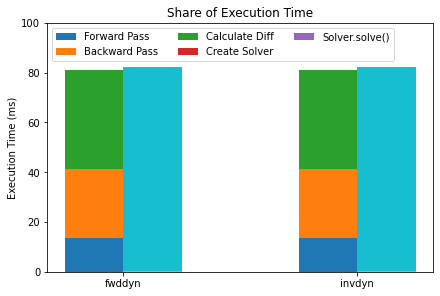

In [69]:
fwd = list()
bwd = list()
cdf = list()
crs = list()
cal = list()
loa = list()

def get_average_of_dir (dir):
    print(dir)
    files = [(x,final_data[dir][x]) for x in final_data[dir].keys()]
    for filename,contents in files:
        characteristics = contents[0]
        average_time = float(re.sub(",","",characteristics["average_execution_set"]))
        if "kernprof" in filename:
            if "forwardPass" in filename:
                fwd.append(average_time)
                
                crs.append(0)
            elif "backwardPass" in filename:
                bwd.append(average_time)
                
                cal.append(0)
            elif "calcDiff" in filename and "DDP" in filename:
                cdf.append(average_time)
                
                loa.append(0)
        if "line" in  filename:
            average_time/=1000
            if "create" in filename:
                crs.append(average_time)
                
                fwd.append(0)
            elif "call" in filename:
                cal.append(average_time)
                
                bwd.append(0)
            elif "load" in filename:
                loa.append(0)
                
                cdf.append(0)
            

labels = (
    'fwddyn',
    'invdyn'
)
dir_names = (
    'fwddyn_kernprof_output_data',
    'fwddyn_line_profiler_output_data',
    'invdyn_kernprof_output_data',
    'invdyn_line_profiler_output_data'
)
for dir in dir_names:
    get_average_of_dir(dir)
    
weight_counts = {
    "Forward Pass": np.array(fwd),#[:2],fwd[2:]]),
    "Backward Pass": np.array(bwd),#[:2],bwd[2:]]),
    "Calculate Diff": np.array(cdf),#[:2],cdf[2:]]),
    "Create Solver": np.array(crs),
    "Solver.solve()": np.array(cal),
    # "Load Robot": np.array(loa)
}
print([*weight_counts.values()])

thing = np.arange(len(labels))  # the label locations
print(thing)
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
bottom = np.zeros(len(dir_names))

# for a in range(2):
#     offset = width * multiplier
#     for legend_key, weight in weight_counts.items():
#         rects = ax.bar(x + offset, height=weight[multiplier], width=width, bottom=bottom[multiplier])
#         bottom[multiplier] =bottom[multiplier]+ weight[multiplier]
#     # bottom = 0
#     ax.bar_label(rects, padding=3)
#     multiplier += 1
# i want 2 sets of bars, each with 2 in them, and 3 color sections

for i in range(4): #4 bars
       for j in range(5): #6 sections
           in_group_index = i%2
           group_index = not i==in_group_index
           rects = ax.bar(
                        x = thing + in_group_index*width, 
                        height=[*weight_counts.values()][j][i], 
                        width=width, 
                        bottom=bottom[i], 
                        # label=legend_key
           )
           bottom[i]+=[*weight_counts.values()][j][i]

    # Add labels to each bar
    # ax.bar_label(rects, padding=3)

ax.set_ylabel('Execution Time (ms)')
ax.set_title('Share of Execution Time')
ax.set_xticks(x + width/2, labels)
ax.legend(loc='upper left', ncol=3, labels=[*weight_counts.keys()])
ax.set_ylim(0, 100)
# ax.set_yscale('log')

plt.show()